In [1]:
import pandas as pd
from os.path import join, isdir, exists, basename, dirname
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from icecream import ic
from src.utils import variant_utils as vu
from glob import glob
from itertools import product
from collections import defaultdict
from tqdm.notebook import tqdm
import pickle

In [2]:
# don_dir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/mt_clones_thresh/"
# #samples = "preB,postB"

# Params
# af_ts = [0.01, 0.1, 0.4, 0.8,]
# oth_af_ts = [0.01, 0.1, 0.4]
# cov_ts = [2, 10, 30] # mean coverage at position for cells with the AF
# oth_cov_ts = [2, 10, 30]  # mean coverage for cells without AF 
# num_cells = [5, 10, 30] # num cells and fraction are for cells with sufficient coverage
# oth_num_cells = [0.25, 0.6, 0.8] # fraction is of cells with sufficient coverage
# mean_pos_cov = [0, 10] #populatiion average coverage at that position


# indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/mt_clones_thresh"
# outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_simpleUnion/plot_mt_clones_thresh"

indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/mt_as_clones/variants_simpleUnion/mt_clones_thresh"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/mt_as_clones/variants_simpleUnion/mt_clones_thresh"
N_DONORS = 2

In [3]:
# use_small = snakemake.params.get("use_small", False)
# to_plots = snakemake.params.get("to_plots", True)
# don_dir = snakemake.input["don_dir"]
# outdir = snakemake.params["outdir"]

# params = snakemake.config["mt_as_clones"]["params"]
# af_ts = params["af_ts"]
# oth_af_ts = params["oth_af_ts"]
# cov_ts = params["cov_ts"]
# oth_cov_ts = params["oth_cov_ts"]
# num_cells = params["num_cells"]
# oth_num_cells = params["oth_num_cells"]
# mean_pos_cov = params["mean_pos_cov"]

In [4]:
cells_dir = join(indir, "cells")
cells_dir

'/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/mt_as_clones/variants_simpleUnion/mt_clones_thresh/cells'

In [5]:
params_d = {}
cell_vars_d = {}

for d in np.arange(N_DONORS): 
    params_d[d] = pd.read_csv(join(indir, f"donor_{d}_thresh_results.tsv"), sep="\t")
    for thresh, curr_df in params_d[d].groupby(["af", "oth_af", "cov", "oth_cov"]):
        print(thresh)
        curr_f = join(cells_dir, f"don.{d}_af.{thresh[0]}_othaf.{thresh[1]}_cov.{thresh[2]}_othcov.{thresh[3]}.p")
        cell_vars_d[(thresh, d)] = pickle.load(open(curr_f,'rb'))    
        clone_cells = set()
        for x in cell_vars_d[(thresh,d)]:
            clone_cells = clone_cells.union(set(cell_vars_d[(thresh,d)][x]["clone_cells"])) 

        params_d[d].loc[curr_df.index, "cells_with_a_var"] = len(clone_cells)
        
        curr_median_cells = {}
        curr_clone_cells = {}
        var_cells = dict()
        for ind, val in curr_df.iterrows():
            if pd.isnull(val["Variants"]):
                continue
            curr_vars = val["Variants"].split(";")
            curr_ncells = []
            curr_cells = set()
            for x in cell_vars_d[(thresh,d)]:
                if x in curr_vars:
                    curr_ncells.append(len(set(cell_vars_d[(thresh,d)])))
                    curr_cells = curr_cells.union(set(cell_vars_d[(thresh,d)][x]["clone_cells"])) 

            curr_median_cells[ind] = np.median(curr_ncells)
            curr_clone_cells[ind] = len(curr_cells)
        curr_median = pd.DataFrame(curr_median_cells, index=["median_cells"]).transpose()
        params_d[d].loc[curr_median.index,"median_cells"] = curr_median["median_cells"]
        params_d[d].loc[curr_median.index,"unique_ncells_captured"] = curr_clone_cells

        curr_df

(0.01, 0.01, 2, 2)
(0.01, 0.01, 2, 10)
(0.01, 0.01, 2, 30)
(0.01, 0.01, 10, 2)
(0.01, 0.01, 10, 10)
(0.01, 0.01, 10, 30)
(0.01, 0.01, 30, 2)
(0.01, 0.01, 30, 10)
(0.01, 0.01, 30, 30)
(0.01, 0.1, 2, 2)
(0.01, 0.1, 2, 10)
(0.01, 0.1, 2, 30)
(0.01, 0.1, 10, 2)
(0.01, 0.1, 10, 10)
(0.01, 0.1, 10, 30)
(0.01, 0.1, 30, 2)
(0.01, 0.1, 30, 10)
(0.01, 0.1, 30, 30)
(0.01, 0.4, 2, 2)
(0.01, 0.4, 2, 10)
(0.01, 0.4, 2, 30)
(0.01, 0.4, 10, 2)
(0.01, 0.4, 10, 10)
(0.01, 0.4, 10, 30)
(0.01, 0.4, 30, 2)
(0.01, 0.4, 30, 10)
(0.01, 0.4, 30, 30)
(0.1, 0.01, 2, 2)
(0.1, 0.01, 2, 10)
(0.1, 0.01, 2, 30)
(0.1, 0.01, 10, 2)
(0.1, 0.01, 10, 10)
(0.1, 0.01, 10, 30)
(0.1, 0.01, 30, 2)
(0.1, 0.01, 30, 10)
(0.1, 0.01, 30, 30)
(0.1, 0.1, 2, 2)
(0.1, 0.1, 2, 10)
(0.1, 0.1, 2, 30)
(0.1, 0.1, 10, 2)
(0.1, 0.1, 10, 10)
(0.1, 0.1, 10, 30)
(0.1, 0.1, 30, 2)
(0.1, 0.1, 30, 10)
(0.1, 0.1, 30, 30)
(0.1, 0.4, 2, 2)
(0.1, 0.4, 2, 10)
(0.1, 0.4, 2, 30)
(0.1, 0.4, 10, 2)
(0.1, 0.4, 10, 10)
(0.1, 0.4, 10, 30)
(0.1, 0.4, 30, 2)
(0.

In [6]:
params_d[d]

,af,oth_af,ncells,oth_ncells,mean_cov,cov,oth_cov,Variants,n_vars,cells_with_a_var,median_cells,unique_ncells_captured
0,0.01,0.01,5,0.25,0,2,2,10397G;10463C;10559G;10589A;11251G;11453A;1171...,68,8275.0,68.0,8275.0
1,0.01,0.01,5,0.25,0,2,10,10397G;10463C;10559G;10589A;11251G;11453A;1171...,68,8275.0,68.0,8275.0
2,0.01,0.01,5,0.25,0,2,30,10397G;10463C;10559G;10589A;11251G;11453A;1171...,68,8275.0,68.0,8275.0
3,0.01,0.01,5,0.25,0,10,2,10397G;10463C;10559G;10589A;11251G;11453A;1171...,68,8275.0,68.0,8275.0
4,0.01,0.01,5,0.25,0,10,10,10397G;10463C;10559G;10589A;11251G;11453A;1171...,68,8275.0,68.0,8275.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1939,0.80,0.40,30,0.80,10,10,10,11251G;11719A;11812G;13368A;14233G;1438G;14766...,33,8275.0,44.0,8275.0
1940,0.80,0.40,30,0.80,10,10,30,11251G;11719A;11812G;13368A;14233G;1438G;14766...,30,8275.0,44.0,8275.0
1941,0.80,0.40,30,0.80,10,30,2,15297C,1,8275.0,44.0,65.0
1942,0.80,0.40,30,0.80,10,30,10,15297C,1,8275.0,44.0,65.0


In [7]:
#     curr_p = params_results.loc[(params_results["af"]==af_t) &
#                        (params_results["oth_af"]==oth_af_t) &
#                        (params_results["cov"]==cov_t) &
#                        (params_results["oth_cov"]==oth_cov_t) &
#                        (params_results["ncells"]==ncells) &
#                        (params_results["oth_ncells"]==oth_ncells) &
#                        (params_results["mean_cov"]==mean_pos_cov)]
#     assert(len(curr_p)==1)
    
#     ## Construct a binary cell-by-variant matrix for the kept variants. 
#     ## Can add N/A if not in oth cells
#     curr_vars = curr_p.iloc[0]["Variants"].split(";")

#     all_cells = set()
#     for x in curr_cells:
#         all_cells = all_cells.union(set(curr_cells[x]["clone_cells"])) 
#         all_cells = all_cells.union(set(curr_cells[x]["other_cells"])) 


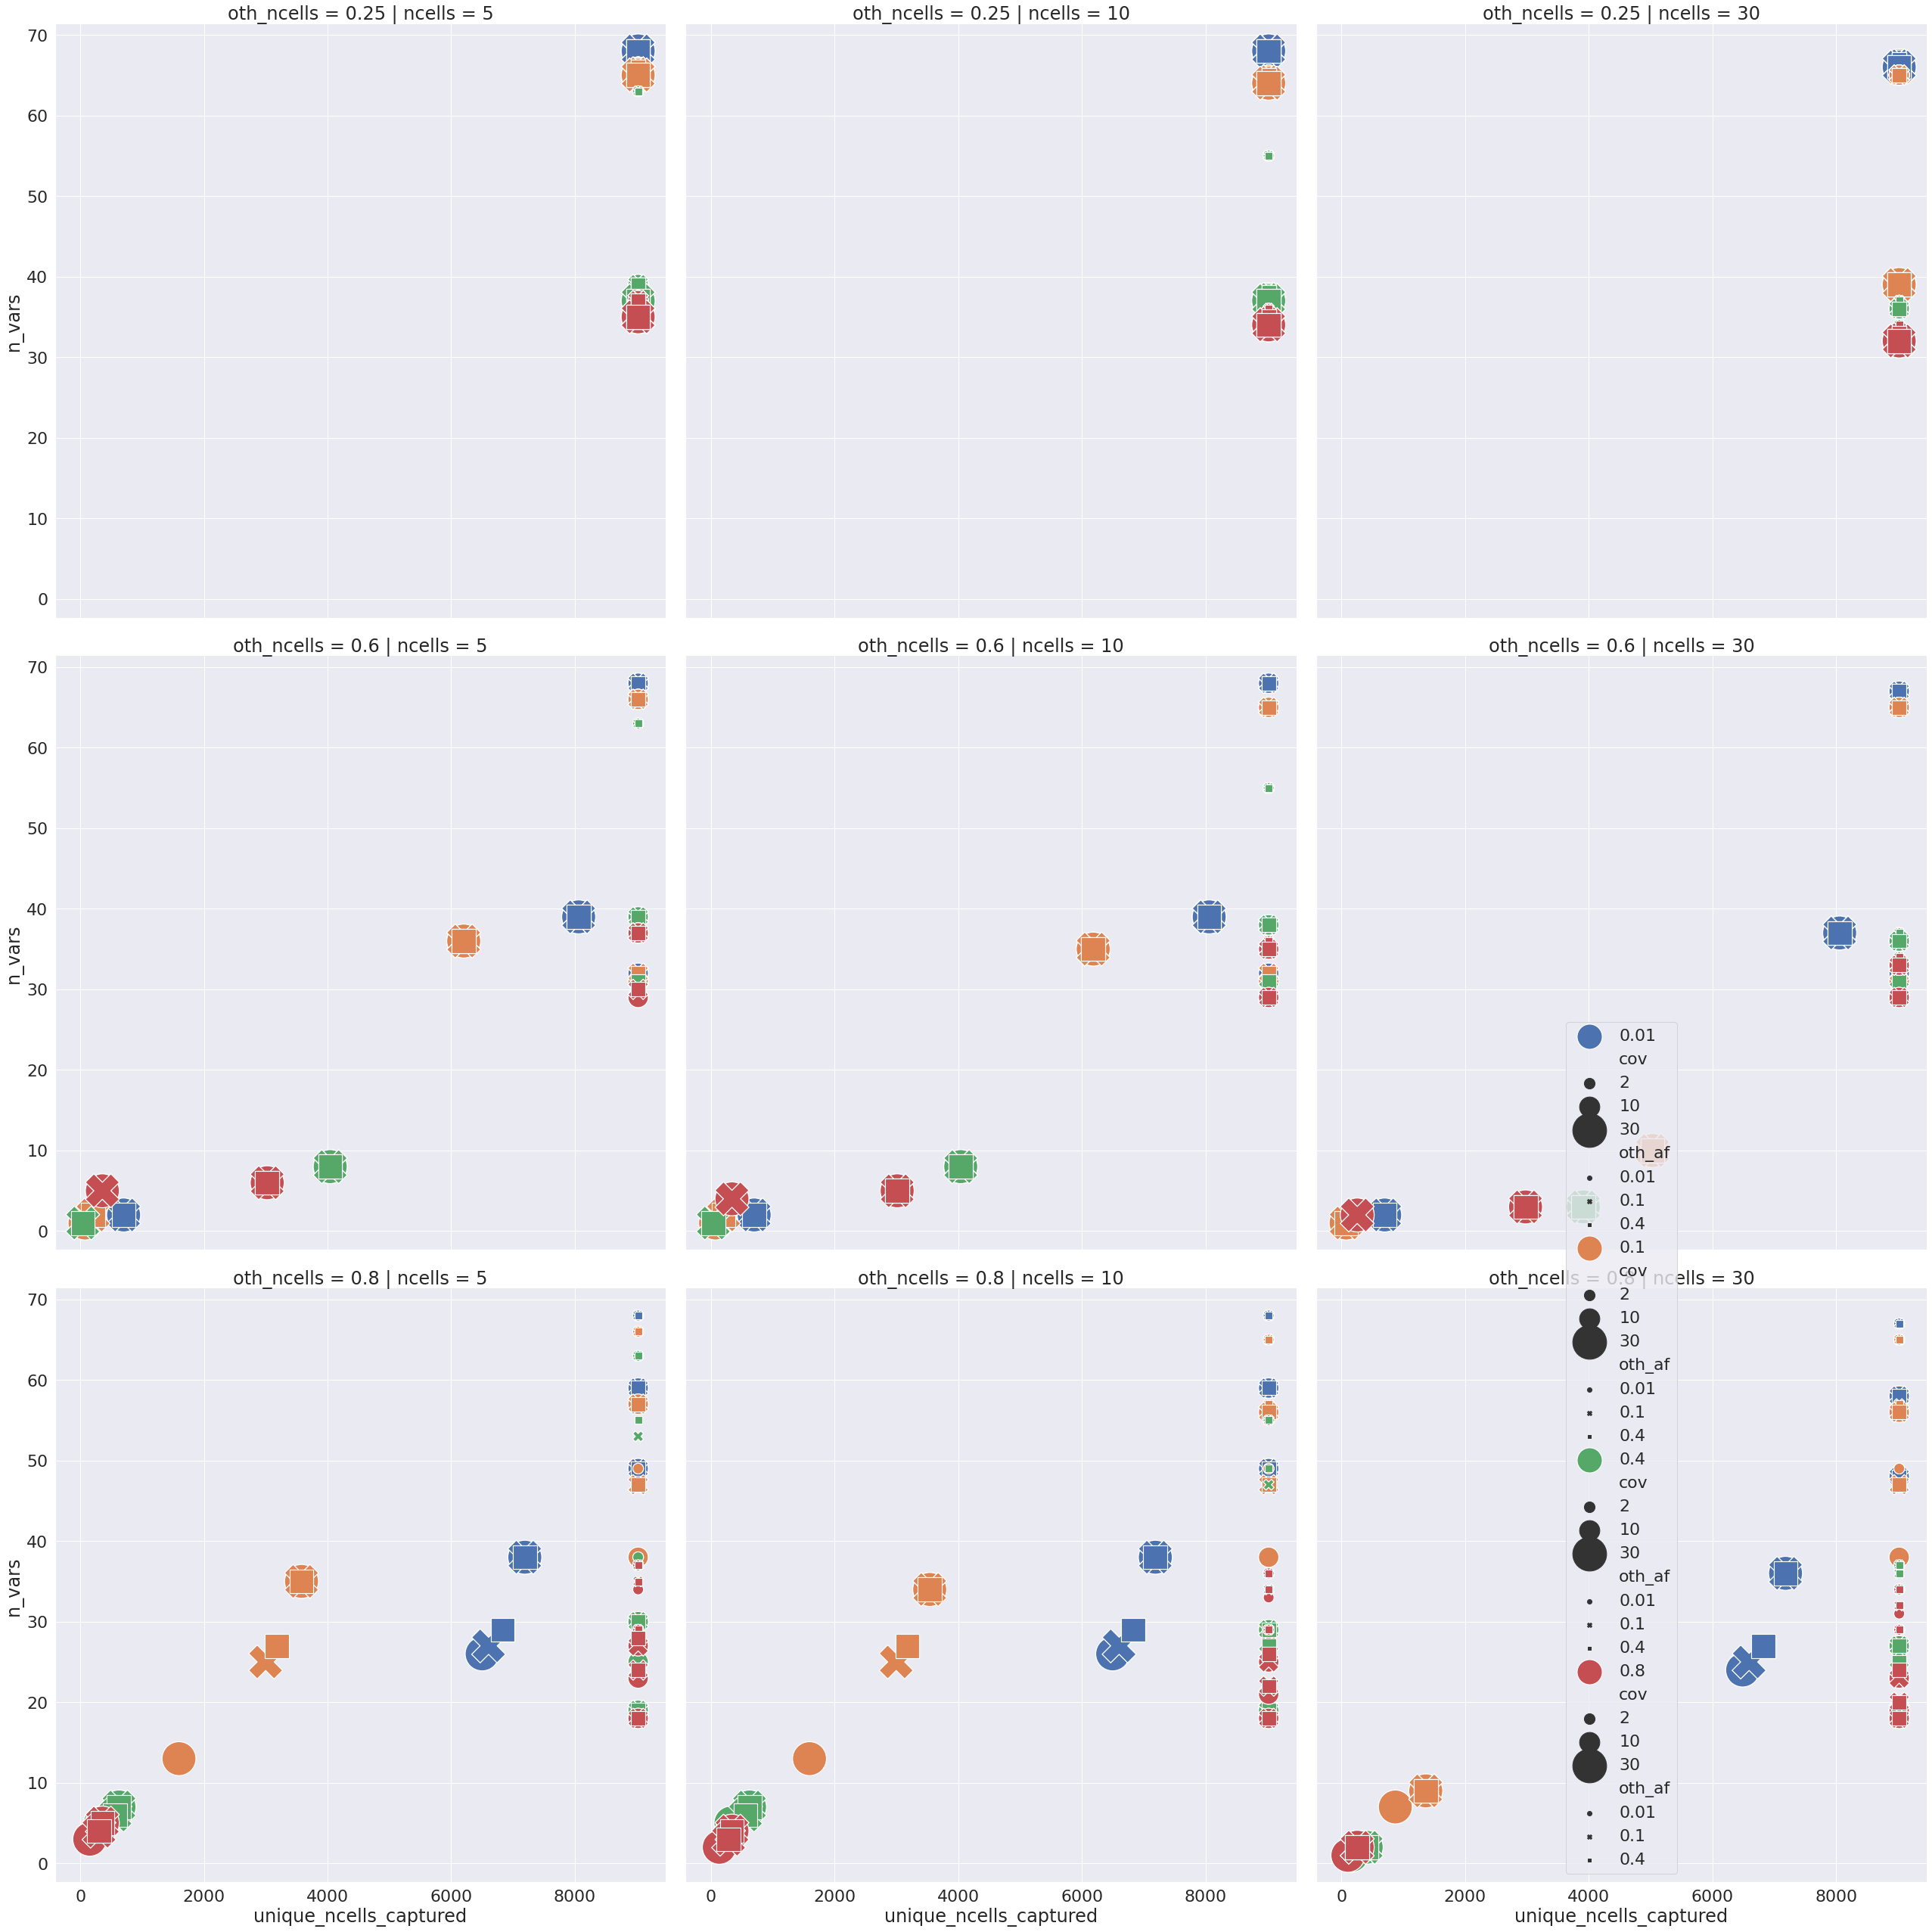

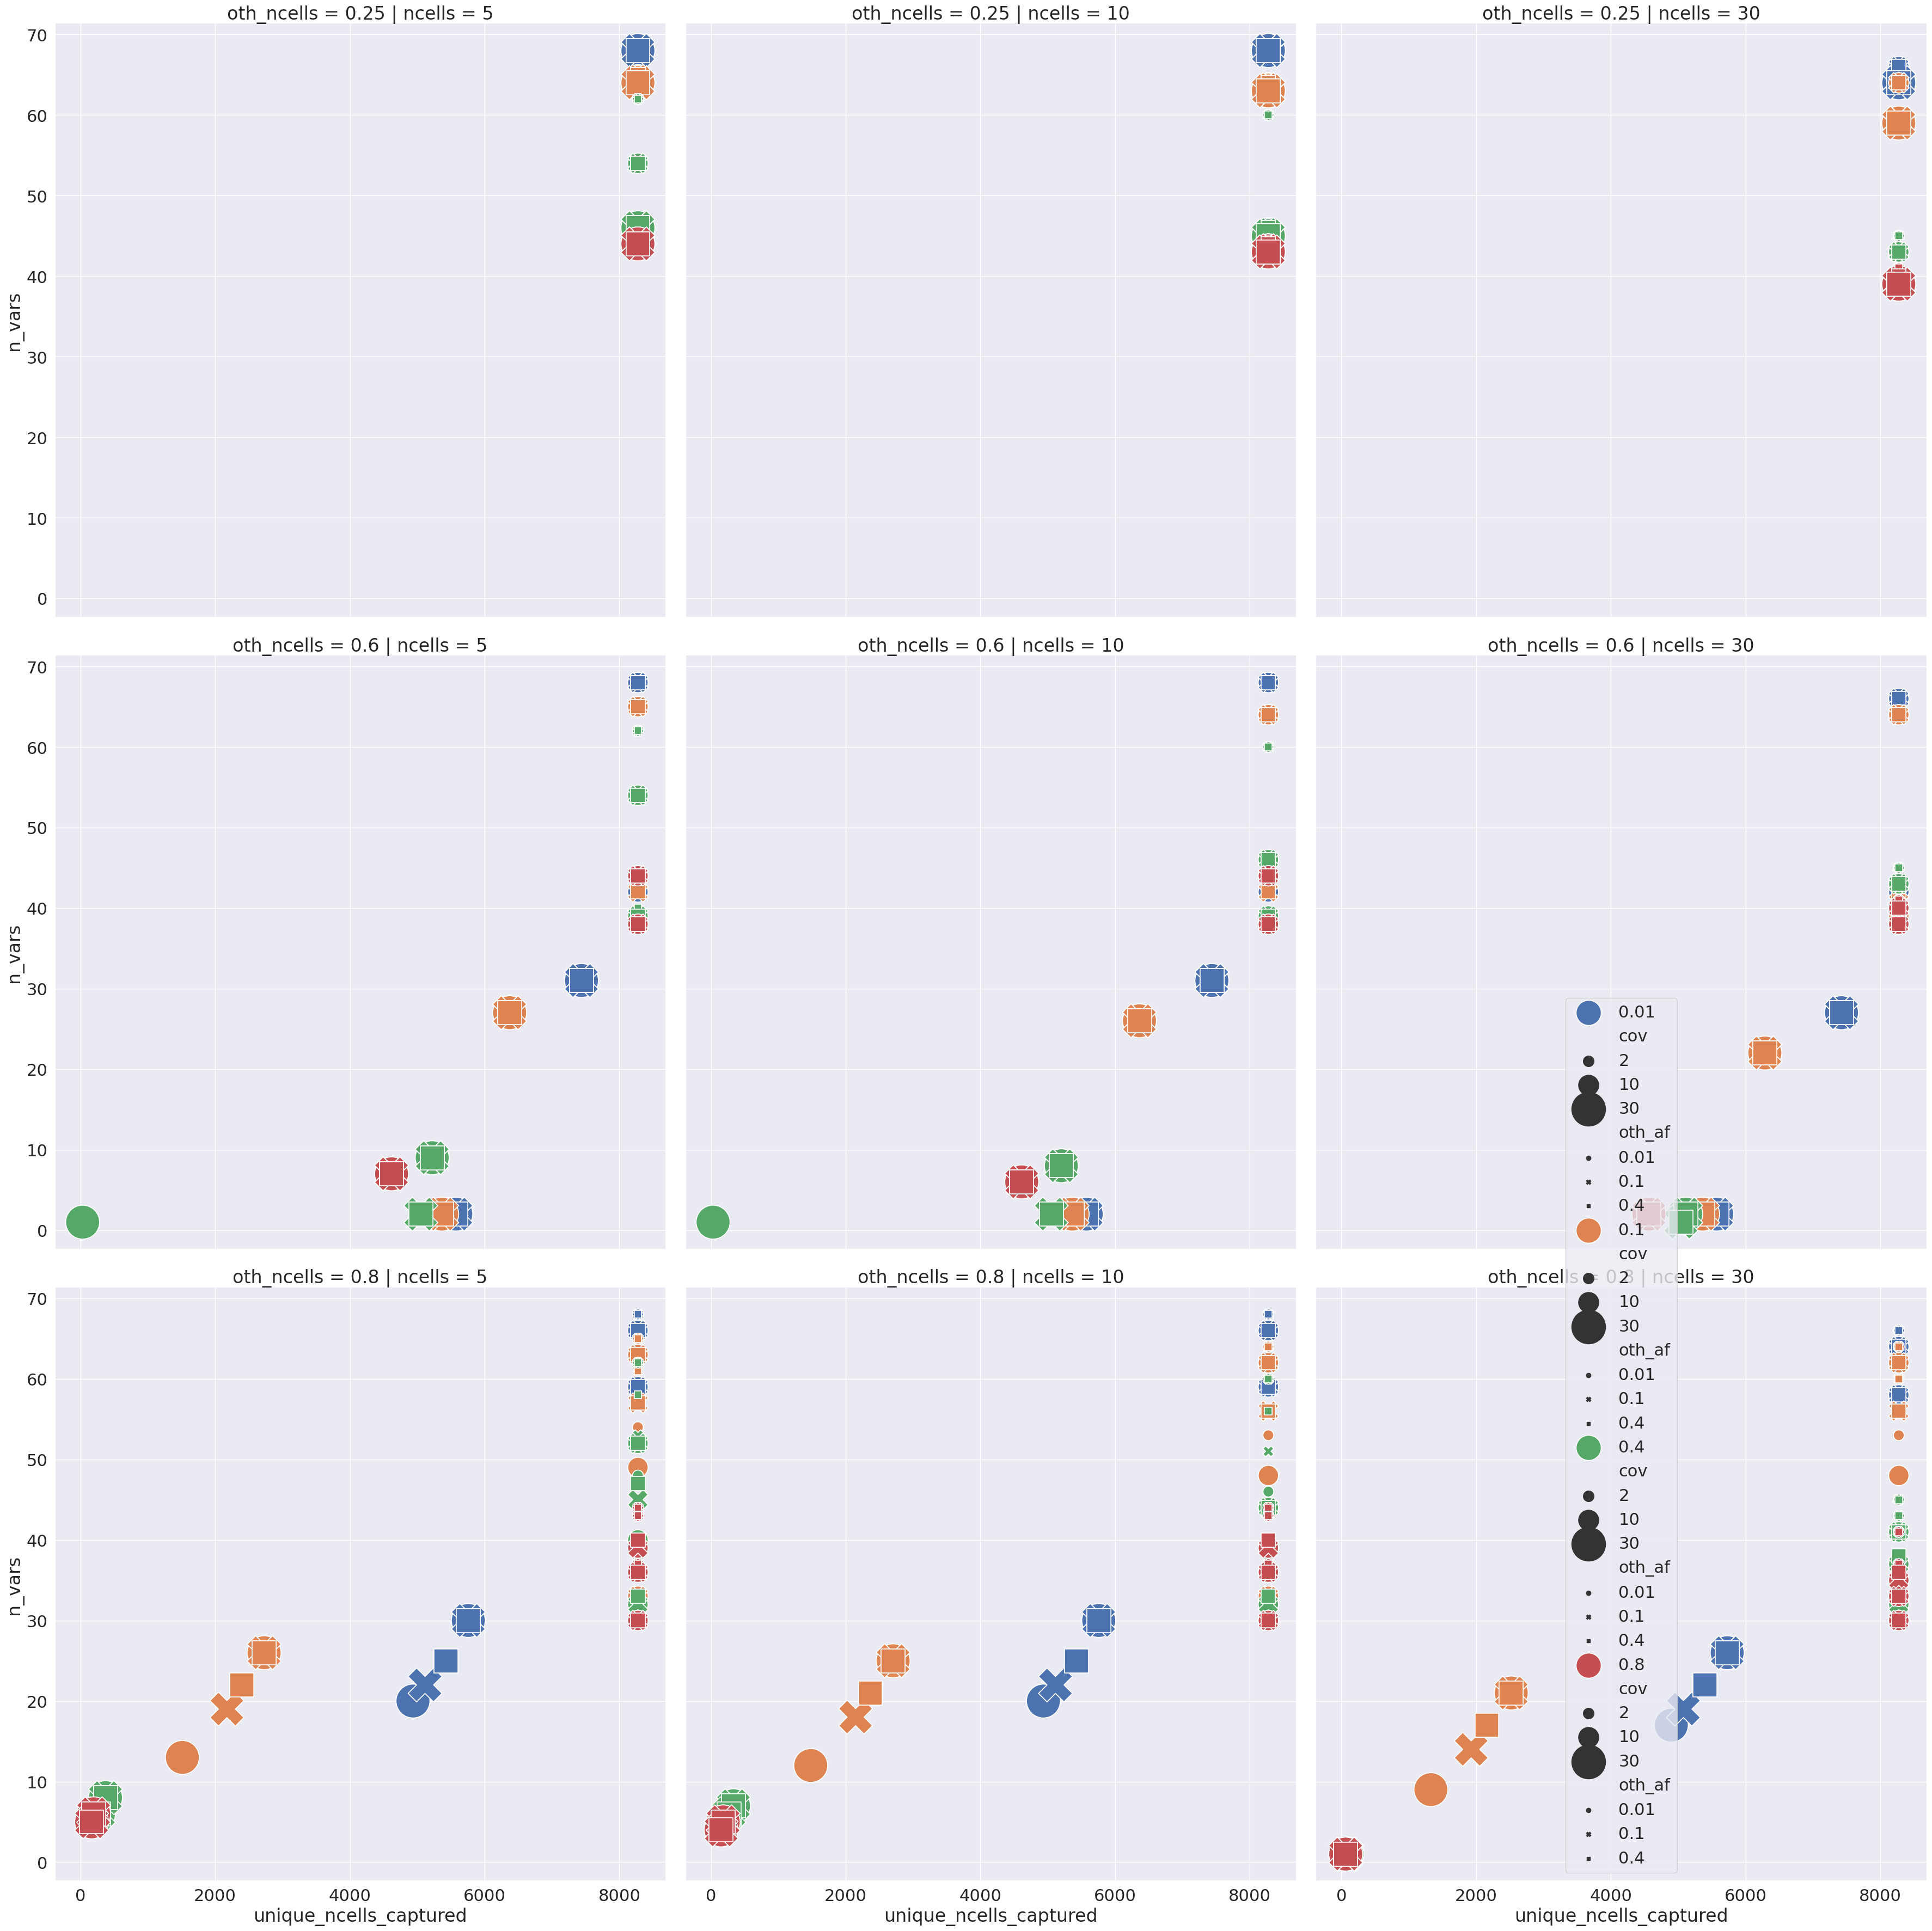

In [8]:
for d in params_d:
    sns.set(font_scale=2)
    g = sns.FacetGrid(data=params_d[d], col="ncells", row="oth_ncells", hue="af", height=12)
    g.map_dataframe(sns.scatterplot, x="unique_ncells_captured", y="n_vars", style="oth_af", size="cov",
                   sizes=(200, 2000), x_jitter=True, y_jitter=True, legend=True)
    plt.legend(loc='best')
    plt.savefig(join(outdir, f"donor{d}_params_scatter.png"))

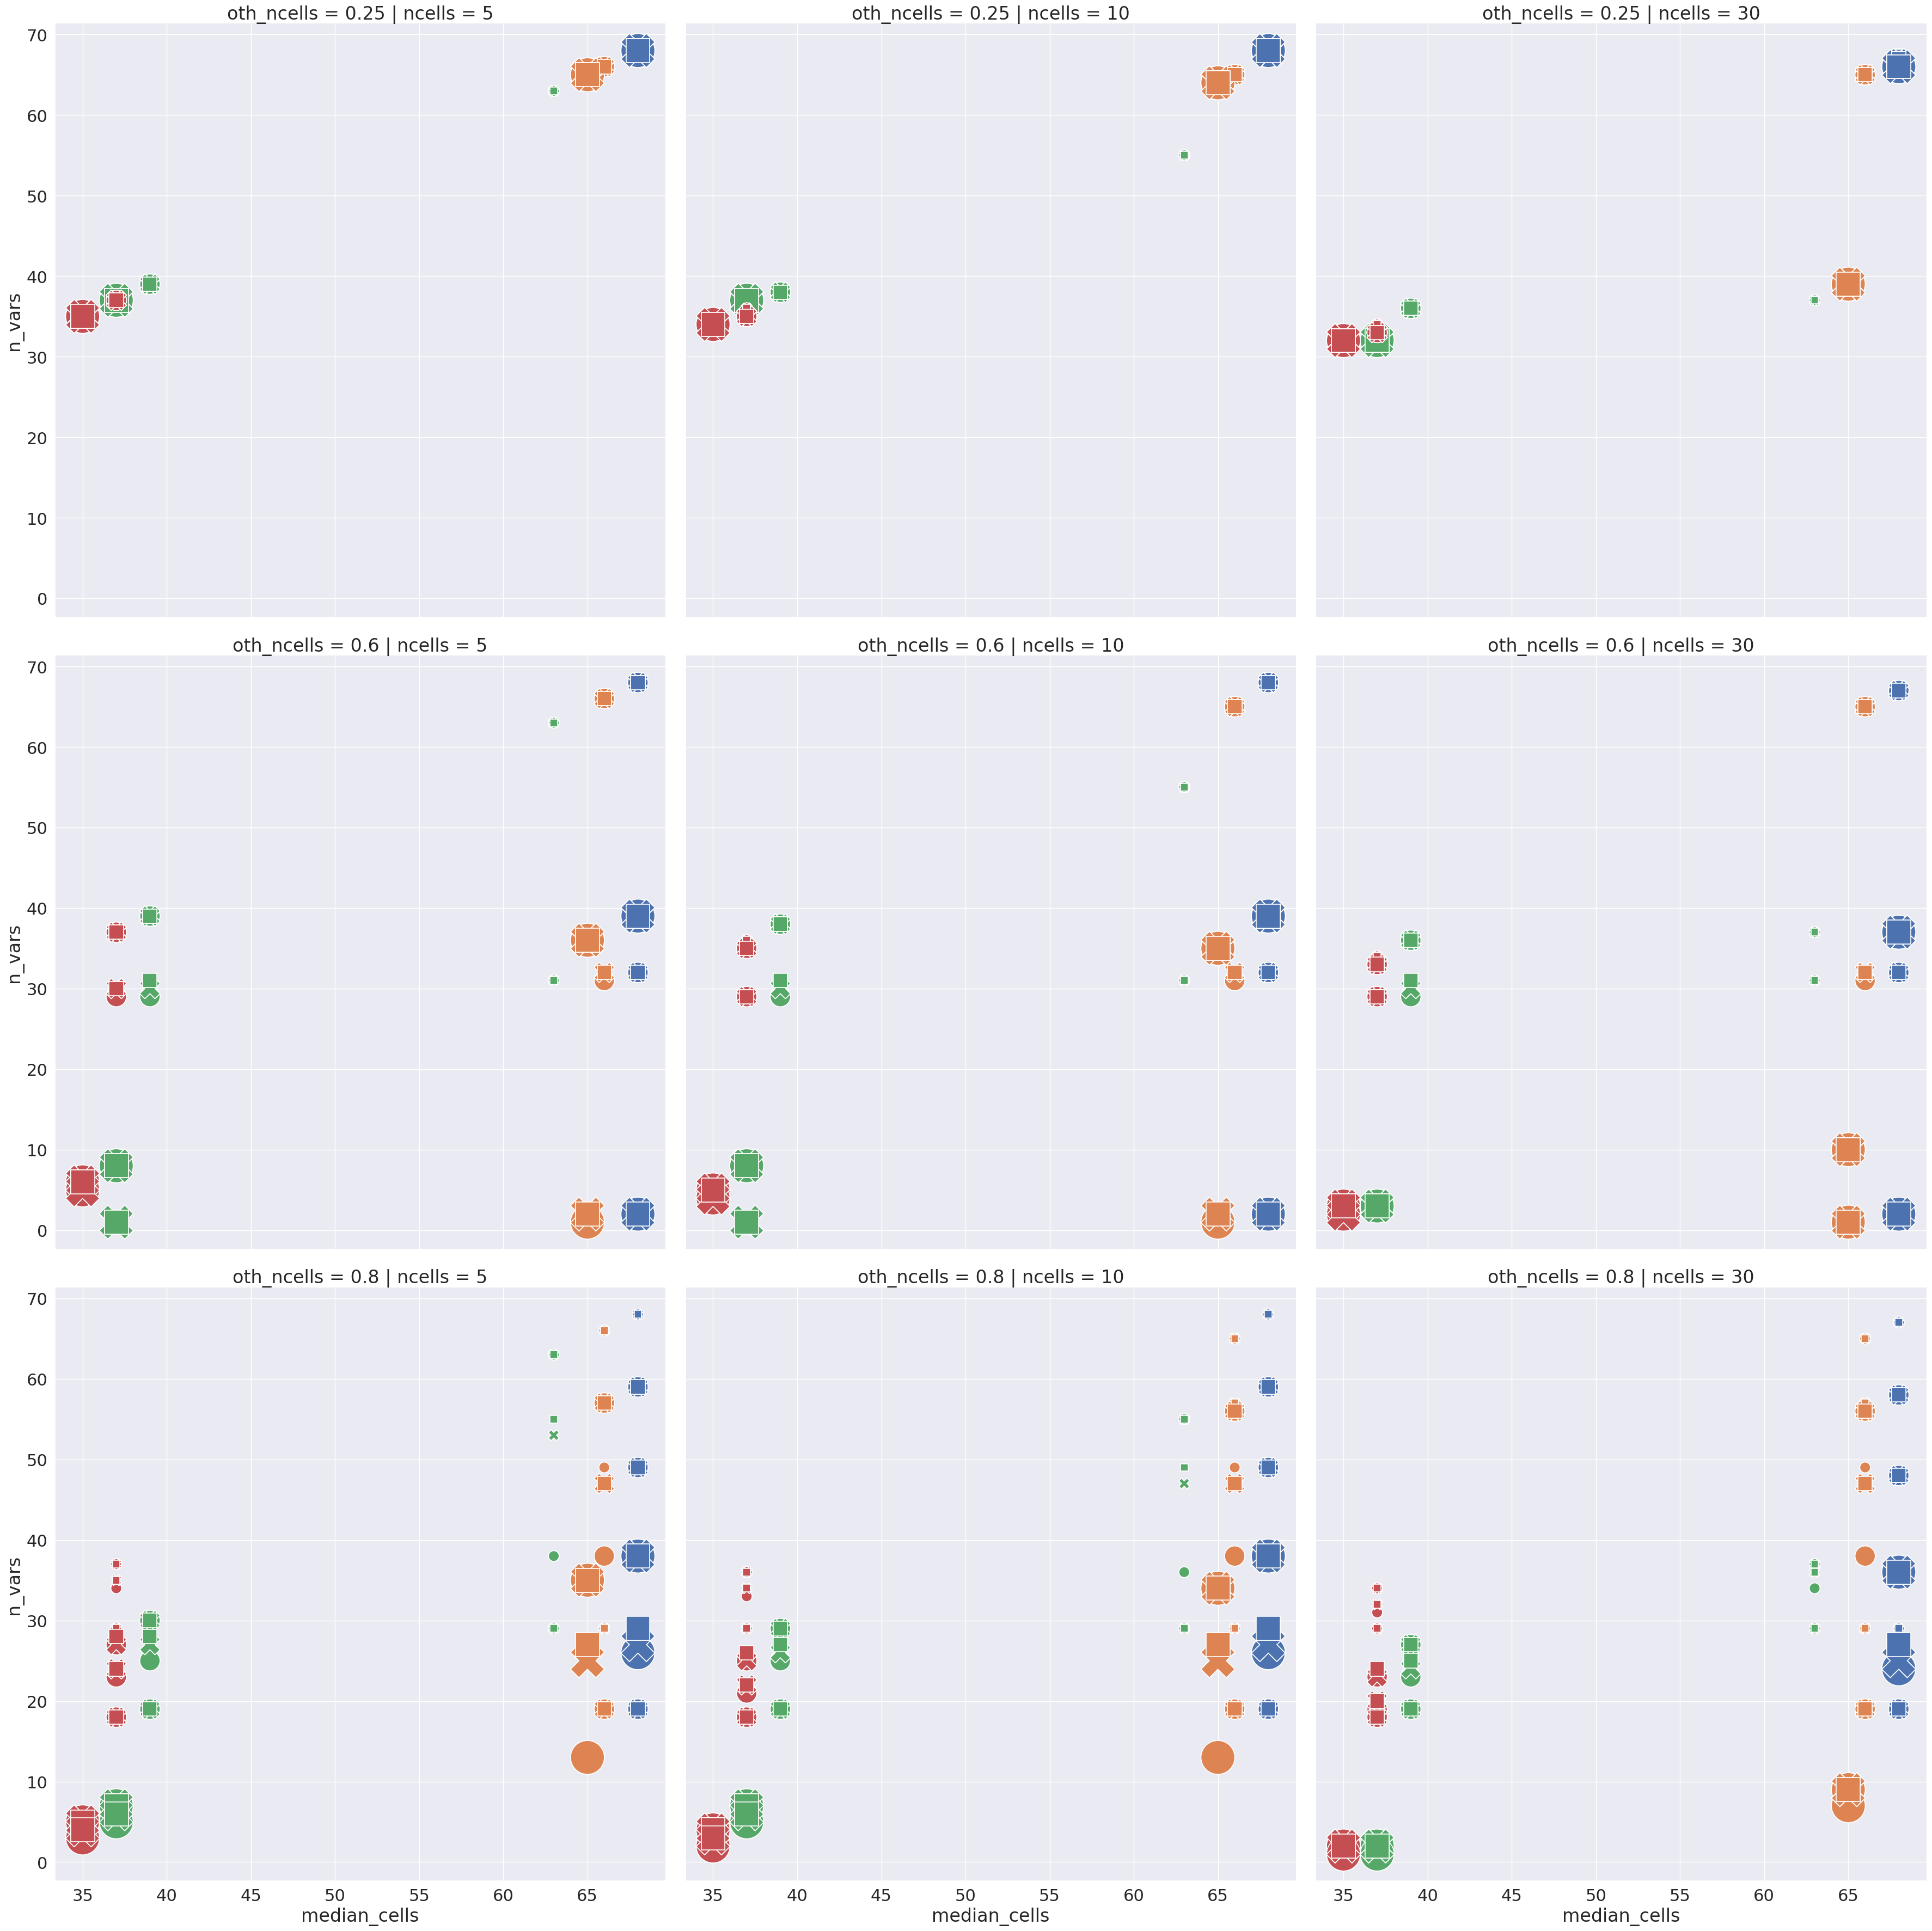

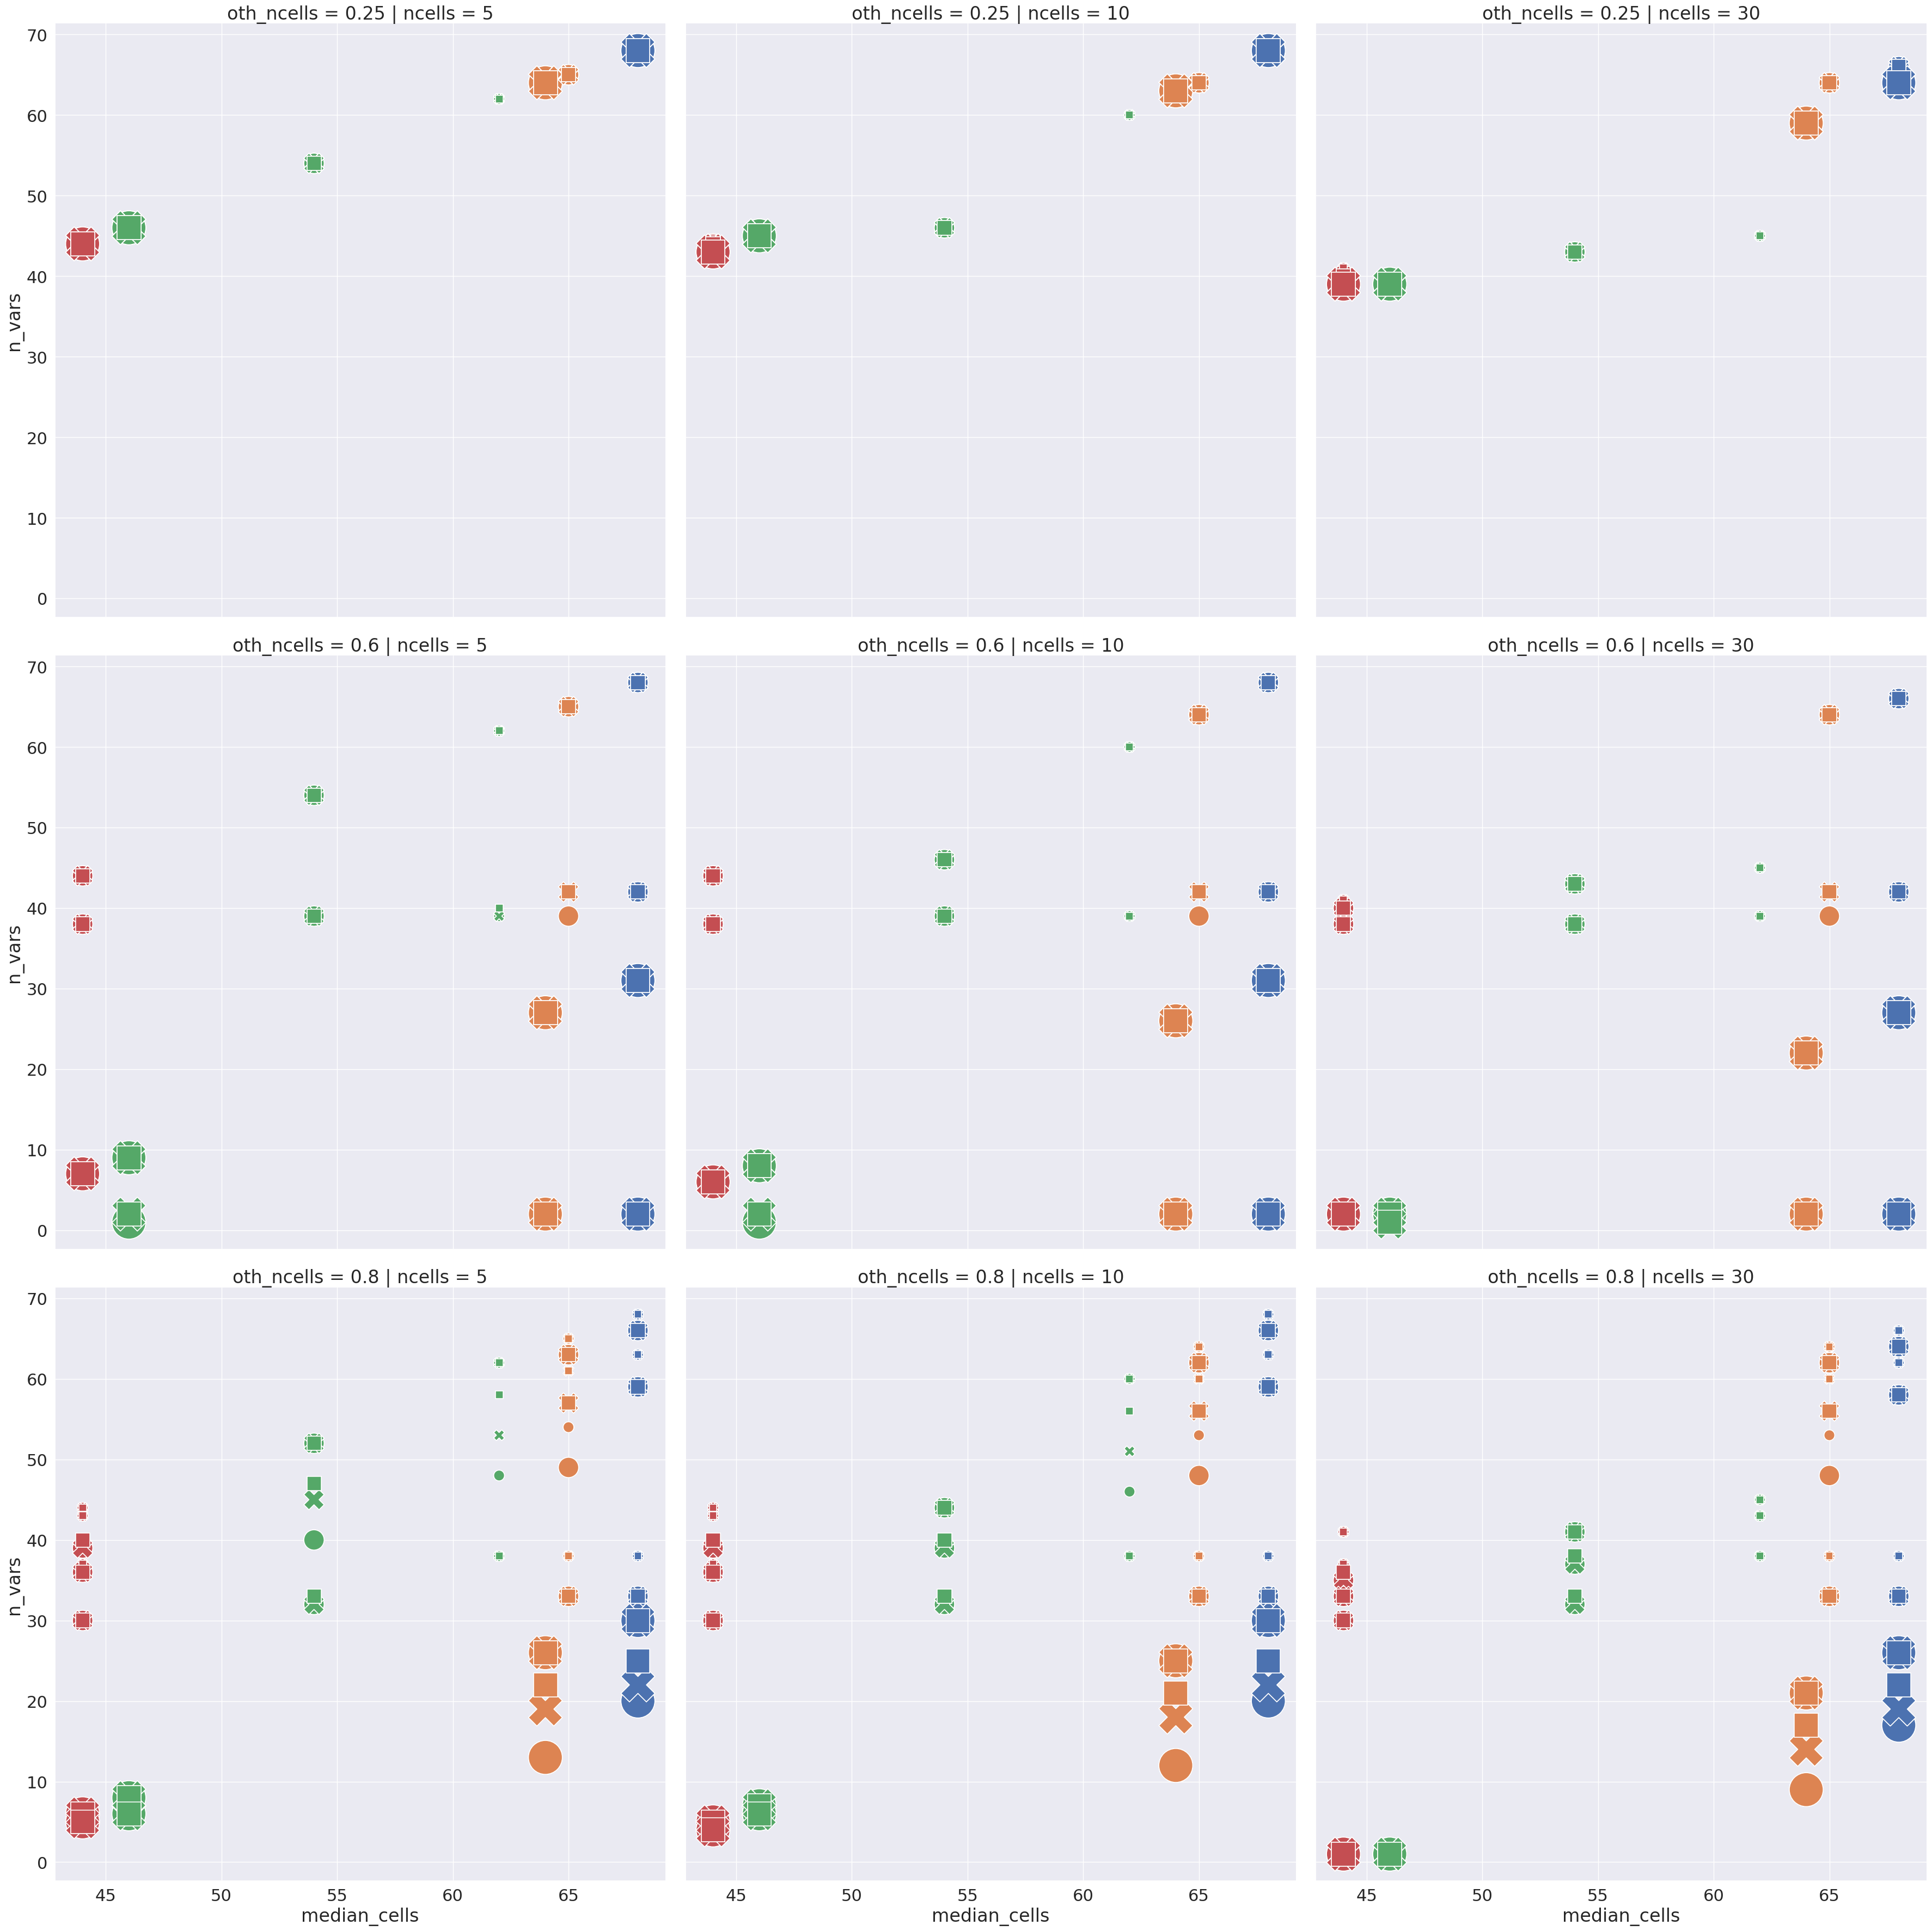

In [9]:
for d in params_d:
    sns.set(font_scale=2)
    g = sns.FacetGrid(data=params_d[d], col="ncells", row="oth_ncells", hue="af", height=12)
    g.map_dataframe(sns.scatterplot, x="median_cells", y="n_vars", style="oth_af", size="cov",
                   sizes=(200, 2000), x_jitter=True, y_jitter=True, legend=True)
    #plt.legend(loc='best')
    plt.savefig(join(outdir, f"donor{d}_params_scatter_median_cells.png"))

In [10]:
outdir

'/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/mt_as_clones/variants_simpleUnion/mt_clones_thresh'

In [11]:
print

<function print>